In [264]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [357]:
# Define a class to receive the characteristics of each object detection
class Detection():
    def __init__(self):
        # history buffer max depth
        self.n_frames = 50
        
        # history of rectangles/detections from previous n frames
        self.prev_rects = []

    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > self.n_frames:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-self.n_frames:]

Number of vehicle images found: 8792
Number of non-vehicle images found: 8968


(-0.5, 437.5, 239.5, -0.5)

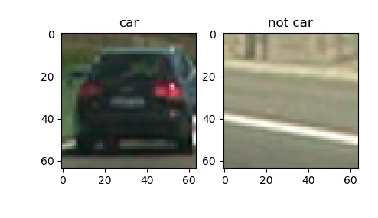

In [128]:
# Read in cars and notcars
    
# Load in the vehicle images to a list
vehicle_img_location = glob.glob('vehicles/*/*.png')
cars = []

# Read in a vehicle image
for f in vehicle_img_location:
    cars.append(f)
    
# Load in the non-vehicle images to a list
nonvehicle_img_location = glob.glob('non-vehicles/*/*.png')
notcars = []

# Read in a non-vehicle image
for f in nonvehicle_img_location:
    notcars.append(f)


print("Number of vehicle images found:", len(cars))
print("Number of non-vehicle images found:", len(notcars))

In [353]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                             pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                  pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        plt.axis('off')
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

    #plt.subplots_adjust(wspace=0.02, hspace=0) 
    #plt.savefig('output_images/sliding_window_examples.jpg', dpi=100, bbox_inches='tight')

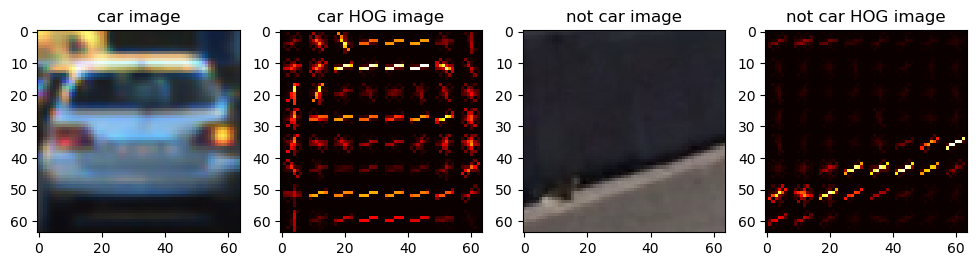

In [261]:
# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, or 2 for this cell 
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, 
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, 
                                                  vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, 
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, 
                                                  vis=True)
                                                                                        
# Visualizer
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'not car image', 'not car HOG image']
fig = plt.figure(figsize=(12,3), dpi=100)
visualize(fig, 1, 4, images, titles)

In [ ]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
#n_samples = 1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(notcars)[random_idxs]
test_cars = cars 
test_notcars = notcars

car_features = extract_features(test_cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size, 
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_scaler = MinMaxScaler(feature_range=(0.1, 0.9)).fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
rand_state = 63
print("rand_state=", rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.25, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear Support Vector Classifier (SVC)
svc = LinearSVC(random_state=rand_state)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save model
data = {
    'svc': svc,
    'color_space': "YCrCb",
    'hog_channel': "ALL",
    'X_scaler': X_scaler,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins
}
#pickle.dump(data, open("model_svc.p", 'wb'))

In [273]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [363]:
# Load a pre-trained SVC model from a serialized (pickle) file
model = pickle.load(open("model_svc.p", "rb"))
# Get attributes of the SVC object
svc = model['svc']
color_space = model['color_space']
hog_channel = model['hog_channel']
X_scaler = model['X_scaler']
orient = model['orient']
pix_per_cell = model['pix_per_cell']
cell_per_block = model['cell_per_block']
spatial_size = model['spatial_size']
hist_bins = model['hist_bins']

# Threshold to determine the best predictions
classification_thresh = 1.2

# Single function to extract features and make predictions
def find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):

    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    
    # Make a heatmap of zeros
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    ctrans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    if scale != 1:
        img_shape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
        
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]        
    ch3 = ctrans_to_search[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step        
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell
            
            # Extract the sub-image patch
            sub_img = cv2.resize(ctrans_to_search[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            #spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make a prediction            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1,-1))
            
            # Predict if there is a car or not
            test_prediction = svc.predict(test_features)
            
            # Predict confidence score for a sample
            # Distance of the sample 'test_features' to the separating hyperplane
            confidence_score = svc.decision_function(test_features)
            
            # Keep the best predictions to manage inevitable false positives
            if ((test_prediction == 1 and confidence_score > classification_thresh) or show_all_rectangles):
                #print(confidence_score)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [275]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 496
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)

print(len(rectangles), 'rectangles found in image')

8 rectangles found in image


In [276]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

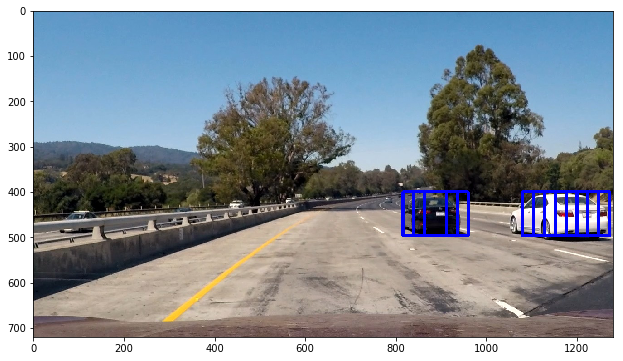

In [280]:
test_img = mpimg.imread('./test_images/test1.jpg')

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10.5, 6))
plt.imshow(test_img_rects)

Number of boxes (top row):  77
Number of boxes (bottom row):  77


Text(0.5,1,'Small Windows Near the Horizon (Scale=1.0)')

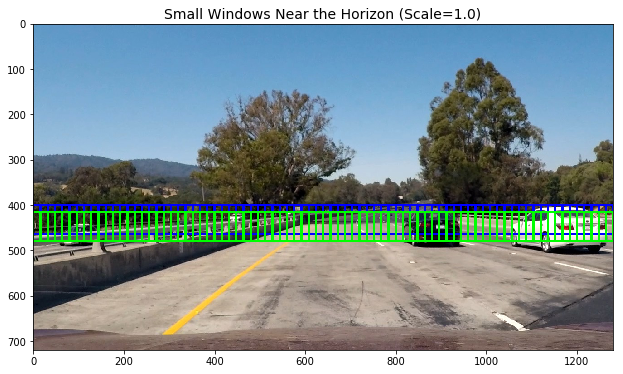

In [281]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row
rects = []
ystart = 400
ystop = 464
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# bottom row, reset to visualize different color 
# show overlap of 75% between top and bottom rows
rects = []
ystart = 416
ystop = 480
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Small Windows Near the Horizon (Scale=1.0)', fontsize=14)
#plt.savefig('output_images/search_window_scale1.0.jpg', dpi=100, bbox_inches='tight')

Number of boxes (top row):  23
Number of boxes (bottom row):  23


Text(0.5,1,'Large Windows in the Center (Scale=3.0)')

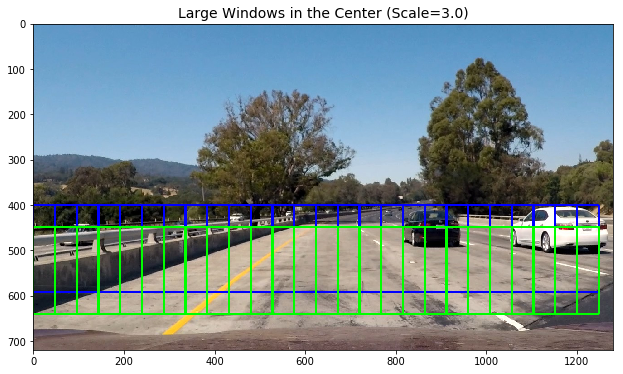

In [282]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row 
rects = []
ystart = 400
ystop = 592
scale = 3.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# bottom row, reset to visualize different color
# show overlap of 75% between top and bottom rows
rects = []
ystart = 448
ystop = 640
scale = 3.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Large Windows in the Center (Scale=3.0)', fontsize=14)
#plt.savefig('output_images/search_window_scale3.0.jpg', dpi=100, bbox_inches='tight')

test_images/test6.jpg
test_images/test5.jpg
test_images/test4.jpg
test_images/test3.jpg
test_images/test2.jpg
test_images/test1.jpg


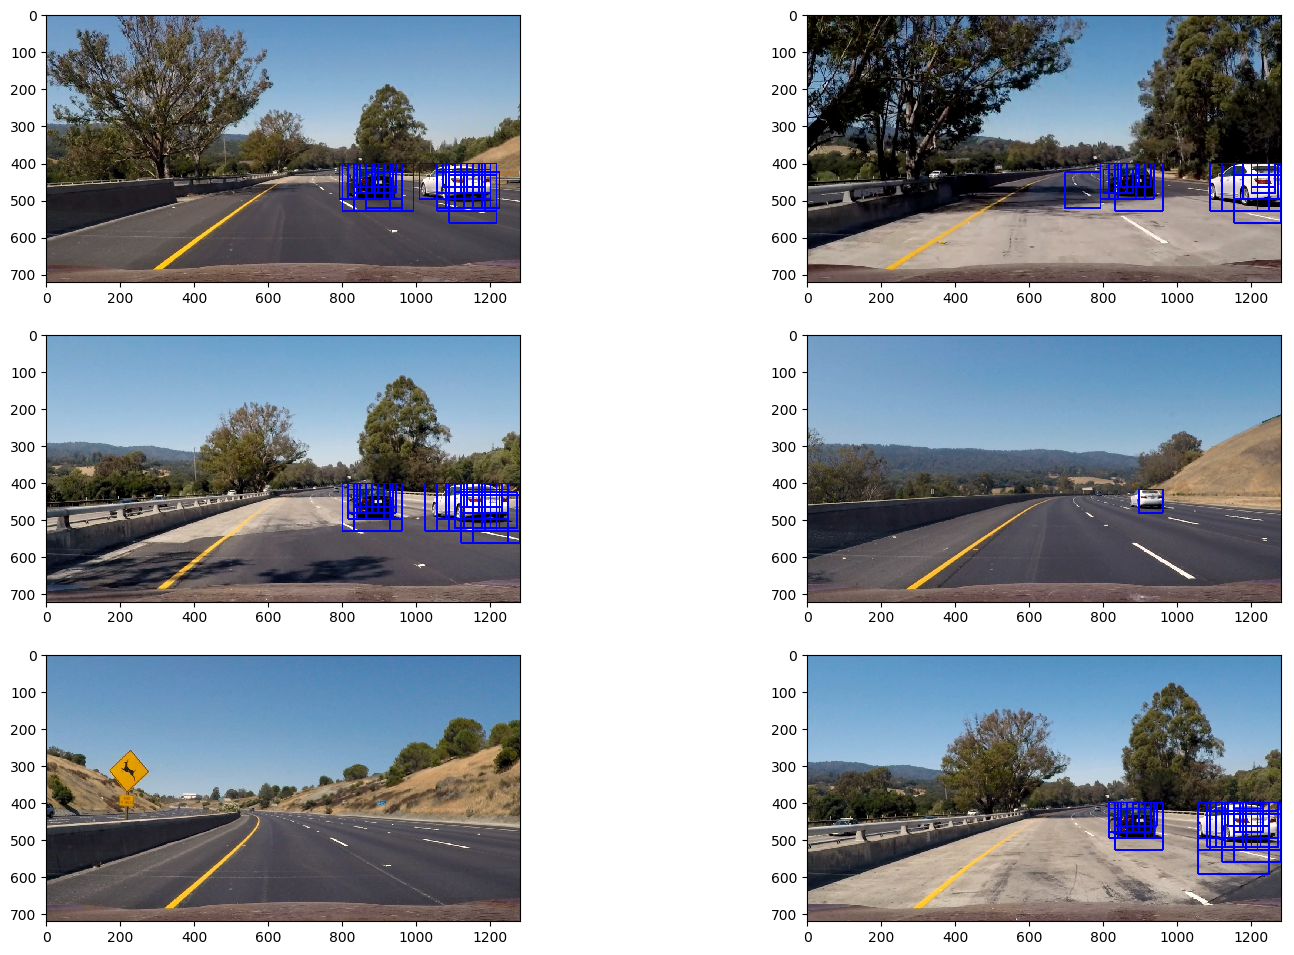

In [294]:
# Run find_cars multiple times to generate
# multi-scaled search windows (1, 1.5x, 2x, 3x)

search_path = 'test_images/*.jpg'
example_images = sorted(glob.glob(search_path), reverse=True)
images = []
titles = []
for img_src in example_images:
    print(img_src)
    t1 = time.time()
    test_img = mpimg.imread(img_src)

    rects = []
    ystart = 400
    ystop = 464
    scale = 1.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 416
    ystop = 480
    scale = 1.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)  


    ystart = 400
    ystop = 496
    scale = 1.5
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 424
    ystop = 520
    scale = 1.5
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 528
    scale = 2.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 560
    scale = 2.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 592
    scale = 3.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 448
    ystop = 640
    scale = 3.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)

    # flatten a list of lists
    rects = [item for sublist in rects for item in sublist] 

    test_img_rects = draw_boxes(test_img, rects, color=(0,0,255), thick=3)
    
    images.append(test_img_rects)
    titles.append('')
    
    #plt.figure(figsize=(10.5,6))
    #plt.imshow(test_img_rects)
    #print('Total Number of boxes: ', len(rects))
    
fig = plt.figure(figsize=(18,12), dpi=100)
visualize(fig, 3, 2, images, titles)

In [297]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

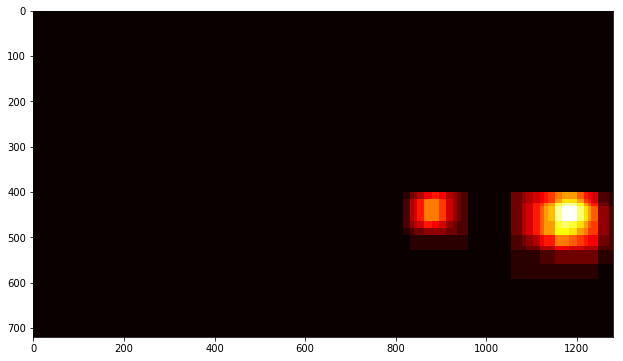

In [304]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rects)
plt.figure(figsize=(10.5, 6))
plt.imshow(heatmap_img, cmap='hot')

In [305]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

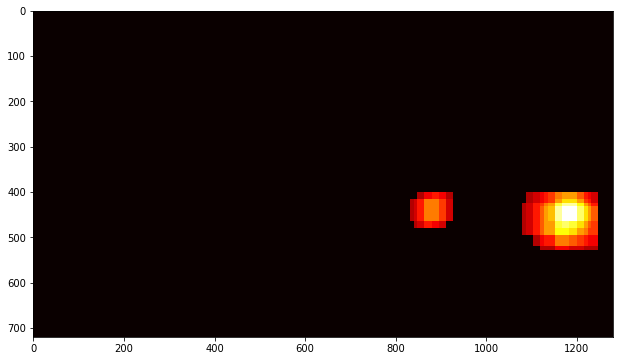

In [310]:
heatmap_thresh = apply_threshold(heatmap_img, 4)
plt.figure(figsize=(10.5, 6))
plt.imshow(heatmap_thresh, cmap='hot')

2 cars found


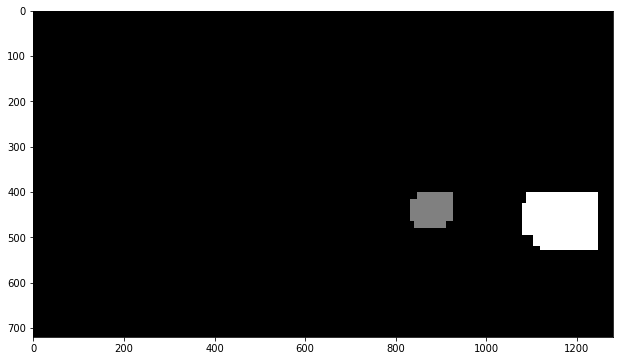

In [311]:
labels = label(heatmap_thresh)
plt.figure(figsize=(10.5, 6))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

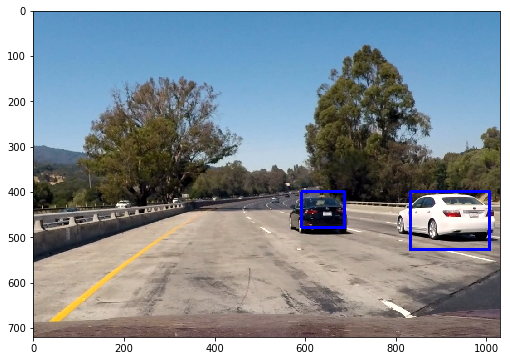

In [352]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)

    # Return the image
    return img, bboxes

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10.5, 6))
plt.imshow(draw_img)
    

test_images/test1.jpg
(720, 1030) (720, 1030)


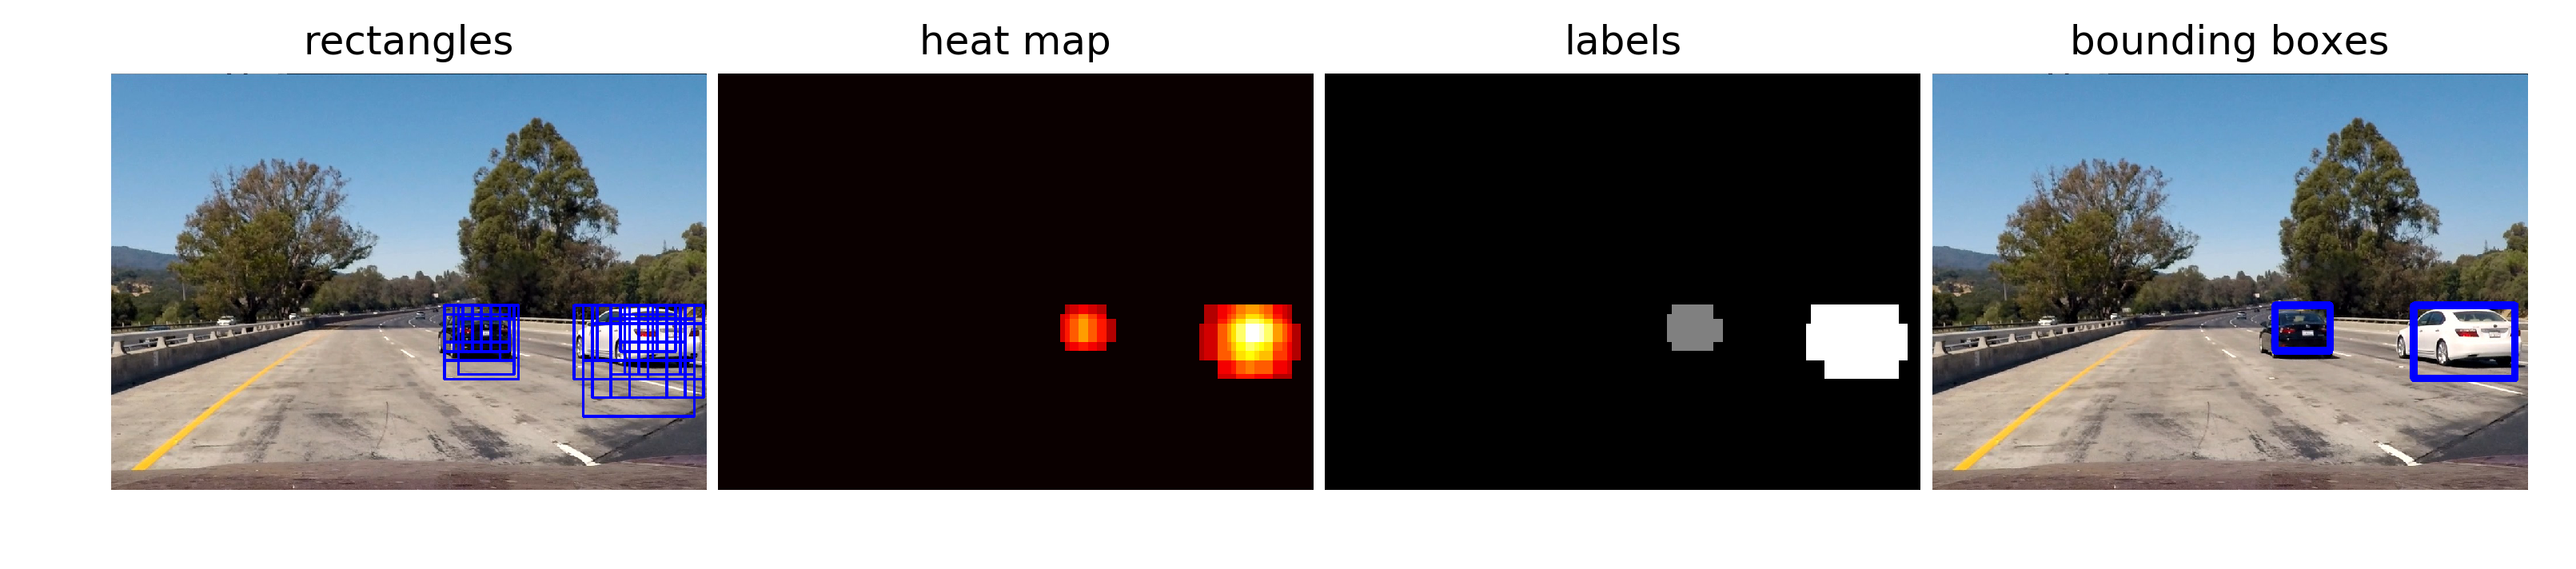

In [364]:
# Run find_cars multiple times to generate
# multi-scaled search windows (1, 1.5x, 2x, 3x)

def process_image(img):
    rects = []

    ystart = 400
    ystop = 464
    scale = 1.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 416
    ystop = 480
    scale = 1.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 496
    scale = 1.5
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 424 
    ystop = 520
    scale = 1.5
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 528
    scale = 2.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 560
    scale = 2.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                    pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 592
    scale = 3.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 448
    ystop = 640
    scale = 3.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)

    # flatten a list of lists..
    rects = [item for sublist in rects for item in sublist] 
    
    # add flattened list of detections to detection history buffer for current frame
    if len(rects) > 0:
        det.add_rects(rects)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    for r in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, r)
        
    # define a heat map threshold based on history buffer size
    det_thresh = 1 + len(det.prev_rects) // 2
    
    # minimum detection threshold to prevent false positives
    # especially when history buffer is less than 3
    min_thresh = 3
    
    # take the larger of the two threshold variables
    thresh = max(det_thresh, min_thresh)
    
    # apply threshold to heat map
    heatmap_thresh = apply_threshold(heatmap_img, thresh)

    # identify individual blobs in the heat map and assign a car label ot it
    labels = label(heatmap_thresh)
    
    # return the bounding box around each detected blob
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [366]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Class object for heat map
det = Detection()

test_output = 'output_video.mp4'
#clip = VideoFileClip("test_video.mp4")
#clip = VideoFileClip("project_video.mp4").subclip(0,11)
clip = VideoFileClip("project_video.mp4")

test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [40:10<00:01,  1.90s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

